# Modo P/Q en el simulador RMS VSC-HVDC

En este notebook vamos a:

- Forzar el modo **P/Q** en el control externo.
- Ajustar las referencias de potencia activa `P_ref` y reactiva `Q_ref`.
- Ejecutar varias simulaciones con distintos valores de `P_ref`.
- Visualizar la respuesta de `P_ac` y `Q_ac` en el tiempo.

> Nota: solo usamos la API pública `run_simulation`.
> No modificamos el modelo ni la ingeniería.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

from vscsim.api.simulation import run_simulation
from vscsim.utils.logger import configure_global_logger_from_config


In [2]:
def load_json(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# Rutas relativas desde notebooks/ hacia tests/data/
params_path = Path("../tests/data/params.json")
scenario_path = Path("../tests/data/scenario.json")

params_base = load_json(params_path)
scenario_base = load_json(scenario_path)

list(params_base.keys()), list(scenario_base.keys())


(['L', 'R', 'Cdc', 'omega', 'V_max', 'Kp_id', 'Kp_iq'],
 ['control_mode',
  'P_ref',
  'Q_ref',
  'v_pcc_d',
  'v_pcc_q',
  'initial_conditions'])

## Configuración del modo P/Q

En este ejemplo:

- Usamos el mismo `scenario_config` base.
- Ajustamos en `params_config`:

  - `mode` = `"PQ"` (clave indicativa usada por el control externo)
  - `P_ref` y `Q_ref` (referencias de potencia activa y reactiva)

Cada experimento será:

- una copia de `params_base`
- con `P_ref` y `Q_ref` modificados
- misma duración (`t_end`) y mismo `dt`


In [3]:
def run_pq_case(
    P_ref: float,
    Q_ref: float,
    t_end: float = 0.5,
    dt: float = 1e-3,
) -> dict:
    """
    Ejecuta una simulación en modo P/Q con P_ref y Q_ref constantes.
    No altera params_base ni scenario_base originales.
    """
    # Copia independiente de parámetros y escenario
    params_config = dict(params_base)
    scenario_config = dict(scenario_base)

    # NO meter strings en params_config (el loader los convierte a float)
    # params_config["mode"] = "PQ"  # ❌ esto rompe load_parameters

    # Saneamos posibles claves NR no numéricas que se hayan colado
    # (por ejecuciones previas del notebook)
    if isinstance(params_config.get("nr_norm"), str):
        params_config.pop("nr_norm", None)
    if isinstance(params_config.get("nr_verbose"), str):
        params_config.pop("nr_verbose", None)

    # Colocamos P_ref / Q_ref donde ya existan (params o escenario)
    if "P_ref" in params_config:
        params_config["P_ref"] = float(P_ref)
    else:
        scenario_config["P_ref"] = float(P_ref)

    if "Q_ref" in params_config:
        params_config["Q_ref"] = float(Q_ref)
    else:
        scenario_config["Q_ref"] = float(Q_ref)

    # Logging ligero
    configure_global_logger_from_config({"log_level": "warning", "log_json": False})

    results = run_simulation(
        params_config=params_config,
        scenario_config=scenario_config,
        t_end=t_end,
        dt=dt,
    )

    return results


In [4]:
P_ref = 0.5
Q_ref = 0.0

results_pq = run_pq_case(P_ref=P_ref, Q_ref=Q_ref, t_end=0.5, dt=1e-3)

time = results_pq["time"]
y_hist = results_pq["y"]

P_series = y_hist.get("P_ac", [])
Q_series = y_hist.get("Q_ac", [])

len(time), len(P_series), len(Q_series)


(501, 501, 501)

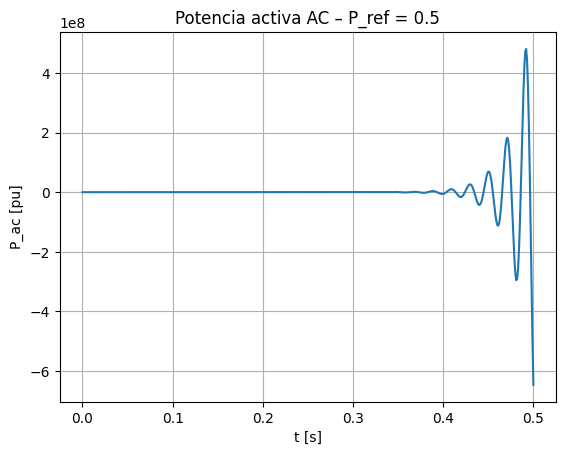

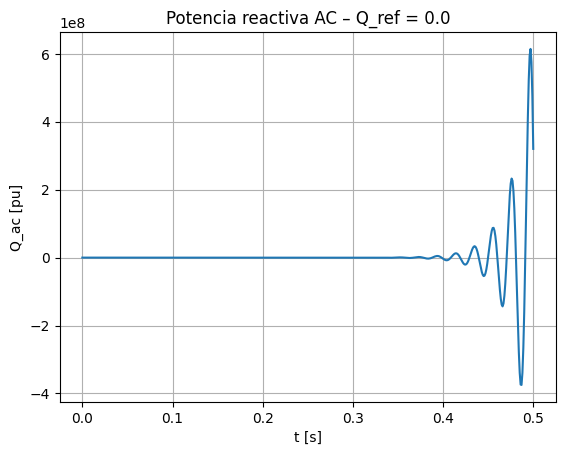

In [5]:
plt.figure()
plt.plot(time, P_series)
plt.xlabel("t [s]")
plt.ylabel("P_ac [pu]")
plt.title(f"Potencia activa AC – P_ref = {P_ref}")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(time, Q_series)
plt.xlabel("t [s]")
plt.ylabel("Q_ac [pu]")
plt.title(f"Potencia reactiva AC – Q_ref = {Q_ref}")
plt.grid(True)
plt.show()


## Barrido de P_ref con Q_ref fija

Ahora vamos a:

- Fijar `Q_ref = 0.0`.
- Ejecutar varios casos con:

  - `P_ref = 0.2`
  - `P_ref = 0.5`
  - `P_ref = 0.8`

y superponer las curvas de `P_ac(t)` para ver cómo sigue la referencia de potencia activa.


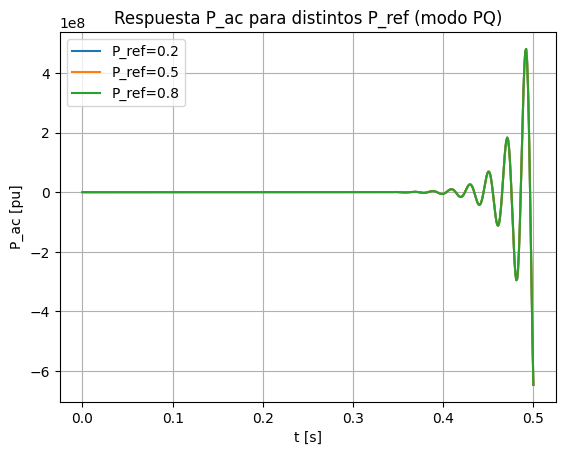

In [6]:
P_refs = [0.2, 0.5, 0.8]
Q_ref = 0.0
t_end = 0.5
dt = 1e-3

all_results = {}

for Pref in P_refs:
    res = run_pq_case(P_ref=Pref, Q_ref=Q_ref, t_end=t_end, dt=dt)
    all_results[Pref] = res

plt.figure()
for Pref, res in all_results.items():
    t = res["time"]
    P_series = res["y"].get("P_ac", [])
    plt.plot(t, P_series, label=f"P_ref={Pref}")
plt.xlabel("t [s]")
plt.ylabel("P_ac [pu]")
plt.title("Respuesta P_ac para distintos P_ref (modo PQ)")
plt.grid(True)
plt.legend()
plt.show()


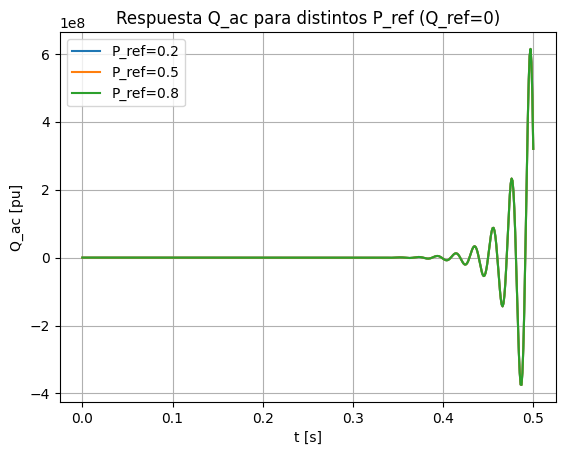

In [7]:
plt.figure()
for Pref, res in all_results.items():
    t = res["time"]
    Q_series = res["y"].get("Q_ac", [])
    plt.plot(t, Q_series, label=f"P_ref={Pref}")
plt.xlabel("t [s]")
plt.ylabel("Q_ac [pu]")
plt.title("Respuesta Q_ac para distintos P_ref (Q_ref=0)")
plt.grid(True)
plt.legend()
plt.show()


## Resumen

En este notebook hemos visto:

- Cómo forzar el modo **PQ** desde `params_config["mode"]`.
- Cómo fijar `P_ref` y `Q_ref` para un caso base.
- Cómo ejecutar varias simulaciones variando `P_ref`.
- Cómo visualizar las respuestas `P_ac` y `Q_ac` del modelo.

En notebooks posteriores:
- Veremos el modo **Vdc/Q**.
- Compararemos integradores y dt adaptativo.
